## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna
# !apt install -y libgl1-mesa-glx
# !pip install albumentations

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 계층적 모델 훈련 함수들 추가
def train_weak_detector_fold(train_df, val_df, fold, device, data_path):
    """취약 클래스 탐지기 훈련 (1개 fold용)"""
    print(f"🔍 Training Weak Detector - Fold {fold+1}")
    
    # 간단한 변환 (빠른 훈련을 위해)
    train_transform = A.Compose([
        A.LongestMaxSize(max_size=224),
        A.PadIfNeeded(min_height=224, min_width=224, border_mode=0, value=0),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.LongestMaxSize(max_size=224),
        A.PadIfNeeded(min_height=224, min_width=224, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    train_dataset = WeakClassDataset(train_df, data_path, train_transform)
    val_dataset = WeakClassDataset(val_df, data_path, val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # 클래스 가중치 (불균형 처리)
    class_counts = train_dataset.df['binary_target'].value_counts()
    weight_ratio = float(class_counts[0] / class_counts[1]) if 1 in class_counts else 1.0  # float() 추가
    class_weights = torch.tensor([1.0, weight_ratio], dtype=torch.float32).to(device)      # dtype 명시
    
    model = WeakClassDetector().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    
    best_f1 = 0.0
    best_model = None
    
    # 간단한 5 에포크 훈련
    for epoch in range(5):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.long().to(device)  # .long() 추가
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # 검증
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.long()  # .long() 추가
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.numpy())
        
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = copy.deepcopy(model.state_dict())
    
    return best_model, best_f1

def train_weak_specializer_fold(train_df, val_df, fold, device, data_path):
    """취약 클래스 전용 분류기 훈련 (1개 fold용)"""
    print(f"🎯 Training Weak Specializer - Fold {fold+1}")
    
    train_transform = A.Compose([
        A.LongestMaxSize(max_size=224),
        A.PadIfNeeded(min_height=224, min_width=224, border_mode=0, value=0),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.LongestMaxSize(max_size=224),
        A.PadIfNeeded(min_height=224, min_width=224, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    train_dataset = WeakClassSpecializerDataset(train_df, data_path, train_transform)
    val_dataset = WeakClassSpecializerDataset(val_df, data_path, val_transform)
    
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print(f"⚠️ No weak class samples in fold {fold+1}, skipping specializer training")
        return None, 0.0
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    
    # 클래스 가중치
    class_dist = train_dataset.df['mapped_target'].value_counts().sort_index()
    total_samples = len(train_dataset)
    class_weights = []
    for i in range(4):
        if i in class_dist.index:
            weight = float(total_samples / (4 * class_dist[i]))  # float() 추가
            class_weights.append(weight)
        else:
            class_weights.append(1.0)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # dtype 명시
    
    model = WeakClassSpecializer().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
    
    best_f1 = 0.0
    best_model = None
    
    # 8 에포크 훈련
    for epoch in range(8):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.long().to(device)  # .long() 추가
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # 검증
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.long()  # .long() 추가
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.numpy())
        
        if len(val_targets) > 0:
            val_f1 = f1_score(val_targets, val_preds, average='macro')
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model = copy.deepcopy(model.state_dict())
    
    return best_model, best_f1

# 계층적 분류를 위한 모델 클래스들
class WeakClassDetector(nn.Module):
    """취약 클래스(3,4,7,14) 탐지를 위한 이진 분류기"""
    def __init__(self, model_name='convnext_tiny', img_size=224):
        super().__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=True, 
            num_classes=2,  # 취약클래스 vs 일반클래스
            drop_rate=0.1
        )
        
    def forward(self, x):
        return self.backbone(x)

class WeakClassSpecializer(nn.Module):
    """취약 클래스(3,4,7,14) 전용 4-class 분류기"""
    def __init__(self, model_name='convnext_small', img_size=224):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=4,  # 클래스 3,4,7,14만 구분
            drop_rate=0.15
        )
        
    def forward(self, x):
        return self.backbone(x)

class HierarchicalDocumentClassifier(nn.Module):
    """조건부 계층적 문서 분류 시스템"""
    def __init__(self, main_model_name='convnext_base_384_in22ft1k'):
        super().__init__()
        
        self.weak_classes = [3, 4, 7, 14]
        self.class_mapping = {3: 0, 4: 1, 7: 2, 14: 3}
        self.reverse_mapping = {0: 3, 1: 4, 2: 7, 3: 14}
        
        # 메인 분류기는 기존 모델과 동일
        self.main_classifier = timm.create_model(
            main_model_name, pretrained=True, num_classes=17
        )
        self.weak_detector = WeakClassDetector()  
        self.weak_specializer = WeakClassSpecializer()
        
        # 조건부 실행을 위한 임계값들
        self.confidence_threshold = 0.8  # 메인 분류기 신뢰도 임계값
        self.weak_class_threshold = 0.6  # 탐지기 임계값
        self.main_weak_confidence_threshold = 0.7  # 메인이 취약클래스 예측시 임계값
        
    def forward(self, x, mode='inference'):
        if mode == 'main':
            return self.main_classifier(x)
        elif mode == 'detector':
            return self.weak_detector(x)
        elif mode == 'specializer':
            return self.weak_specializer(x)
        elif mode == 'inference':
            return self.conditional_hierarchical_inference(x)
            
    def conditional_hierarchical_inference(self, x):
        """조건부 계층적 추론 - 필요할 때만 탐지기 실행"""
        batch_size = x.size(0)
        final_predictions = torch.zeros(batch_size, 17).to(x.device)
        
        # 1단계: 메인 분류기만 먼저 실행
        main_logits = self.main_classifier(x)
        main_probs = torch.softmax(main_logits, dim=1)
        main_confidence, main_preds = torch.max(main_probs, dim=1)
        
        # 2단계: 조건 확인 - 탐지기 실행이 필요한 샘플들 찾기
        needs_detection = torch.zeros(batch_size, dtype=torch.bool).to(x.device)
        
        for i in range(batch_size):
            main_pred = main_preds[i].item()
            main_conf = main_confidence[i].item()
            
            # 탐지기 실행 조건들
            condition1 = main_pred in self.weak_classes and main_conf < self.main_weak_confidence_threshold
            condition2 = main_conf < self.confidence_threshold
            
            needs_detection[i] = condition1 or condition2
        
        # 3단계: 조건부 탐지기 실행
        detection_indices = torch.where(needs_detection)[0]
        
        if len(detection_indices) > 0:
            # 필요한 샘플들만 탐지기에 입력
            suspicious_samples = x[detection_indices]
            detector_logits = self.weak_detector(suspicious_samples)
            detector_probs = torch.softmax(detector_logits, dim=1)
            weak_class_probs = detector_probs[:, 1]  # 취약클래스 확률
            
            # 4단계: 전용 분류기 사용 여부 결정
            for idx_in_batch, sample_idx in enumerate(detection_indices):
                main_pred = main_preds[sample_idx].item()
                main_conf = main_confidence[sample_idx].item()
                weak_prob = weak_class_probs[idx_in_batch].item()
                
                # 전용 분류기 사용 조건
                use_specializer = (
                    (main_pred in self.weak_classes and main_conf < self.main_weak_confidence_threshold) or
                    (weak_prob > self.weak_class_threshold)
                )
                
                if use_specializer:
                    # 전용 분류기 실행 (단일 샘플)
                    single_sample = x[sample_idx:sample_idx+1]
                    specializer_logits = self.weak_specializer(single_sample)
                    specializer_probs = torch.softmax(specializer_logits, dim=1)
                    spec_pred = torch.argmax(specializer_probs, dim=1).item()
                    final_class = self.reverse_mapping[spec_pred]
                    final_predictions[sample_idx, final_class] = 1.0
                else:
                    # 메인 분류기 결과 사용
                    final_predictions[sample_idx] = main_probs[sample_idx]
        
        # 5단계: 탐지가 필요없던 샘플들은 메인 결과 사용
        no_detection_indices = torch.where(~needs_detection)[0]
        for sample_idx in no_detection_indices:
            final_predictions[sample_idx] = main_probs[sample_idx]
                
        return final_predictions
    
    def get_inference_stats(self, x):
        """추론 과정 통계 반환 (디버깅용)"""
        batch_size = x.size(0)
        
        # 메인 분류기 실행
        main_logits = self.main_classifier(x)
        main_probs = torch.softmax(main_logits, dim=1)
        main_confidence, main_preds = torch.max(main_probs, dim=1)
        
        # 조건 확인
        needs_detection = torch.zeros(batch_size, dtype=torch.bool).to(x.device)
        for i in range(batch_size):
            main_pred = main_preds[i].item()
            main_conf = main_confidence[i].item()
            
            condition1 = main_pred in self.weak_classes and main_conf < self.main_weak_confidence_threshold
            condition2 = main_conf < self.confidence_threshold
            needs_detection[i] = condition1 or condition2
        
        detection_count = needs_detection.sum().item()
        
        stats = {
            'total_samples': batch_size,
            'detection_needed': detection_count,
            'detection_ratio': detection_count / batch_size if batch_size > 0 else 0,
            'main_only_samples': batch_size - detection_count,
            'avg_main_confidence': main_confidence.mean().item(),
            'weak_class_predictions': sum(1 for pred in main_preds if pred.item() in self.weak_classes)
        }
        
        return stats

# 취약 클래스 탐지용 이진 분류 데이터셋
class WeakClassDataset(Dataset):
    """취약 클래스 탐지용 이진 분류 데이터셋"""
    def __init__(self, data, path, transform=None, weak_classes=[3, 4, 7, 14]):
        if isinstance(data, str):
            self.df = pd.read_csv(data)
        else:
            self.df = data.copy()
        
        self.path = path
        self.transform = transform
        self.weak_classes = weak_classes
        
        # 이진 레이블 생성 (취약클래스: 1, 나머지: 0)
        self.df['binary_target'] = self.df['target'].apply(
            lambda x: 1 if x in weak_classes else 0
        ).astype(int)  # int 타입으로 명시적 변환
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.path, row['ID'])
        img = np.array(Image.open(img_path).convert('RGB'))
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        return img, int(row['binary_target'])  # int()로 확실히 정수 타입으로 변환

class WeakClassSpecializerDataset(Dataset):
    """취약 클래스 전용 4-class 데이터셋"""
    def __init__(self, data, path, transform=None, weak_classes=[3, 4, 7, 14]):
        if isinstance(data, str):
            df = pd.read_csv(data)
        else:
            df = data.copy()
        
        # 취약 클래스만 필터링
        self.df = df[df['target'].isin(weak_classes)].reset_index(drop=True)
        self.path = path
        self.transform = transform
        
        # 클래스 매핑 (3->0, 4->1, 7->2, 14->3)
        self.class_mapping = {3: 0, 4: 1, 7: 2, 14: 3}
        self.df['mapped_target'] = self.df['target'].map(self.class_mapping).astype(int)  # int 타입으로 명시
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.path, row['ID'])
        img = np.array(Image.open(img_path).convert('RGB'))
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        return img, int(row['mapped_target'])

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'
# model_name = 'convnextv2_base.fcmae_ft_in22k_in1k_384'
# model_name = 'vit_base_patch16_clip_384.laion2b_ft_in12k_in1k' # openclip
# model_name = 'vit_base_patch16_384.augreg_in1k' # augreg
# model_name = 'eva02_enormous_patch14_plus_clip_224.laion2b_s9b_b144k' # eva-02 멀티모달
# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용
# model_name = 'vit_base_patch14_reg4_dinov2.lvd142m' # dinov2 reg4

# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용

# training config
img_size = 512
LR = 2e-4
EPOCHS = 64
BATCH_SIZE = 10
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [10]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장
detector_models = []      #  각 fold의 탐지기 모델 저장
specializer_models = []   #  각 fold의 전용 분류기 모델 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    print(f"\n🎯 Training hierarchical models for Fold {fold + 1}")
    
    # 취약 클래스 탐지기 훈련
    detector_state, detector_f1 = train_weak_detector_fold(
        train_fold_df, val_fold_df, fold, device, "../data/train/"
    )

    # 취약 클래스 전용 분류기 훈련  
    specializer_state, specializer_f1 = train_weak_specializer_fold(
        train_fold_df, val_fold_df, fold, device, "../data/train/"
    )
    
    # 계층적 모델 결과 저장
    detector_models.append(detector_state)
    specializer_models.append(specializer_state)
    
    print(f"Fold {fold + 1} - Main F1: {best_val_f1:.4f}, Detector F1: {detector_f1:.4f}, Specializer F1: {specializer_f1:.4f}")

    # 현재 fold 결과 저장 
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'detector_f1': detector_f1,        # 새로 추가
        'specializer_f1': specializer_f1,  # 새로 추가
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.3613: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s]

Epoch  1 | Train Loss: 1.7130 | Train F1: 0.4807 | Val Loss: 0.8217 | Val F1: 0.7934



Val Loss: 1.0099: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]

Epoch  2 | Train Loss: 0.9988 | Train F1: 0.7023 | Val Loss: 0.8188 | Val F1: 0.8038



Val Loss: 0.4577: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]

Epoch  3 | Train Loss: 0.8415 | Train F1: 0.7273 | Val Loss: 0.5630 | Val F1: 0.8967



Val Loss: 0.6486: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]

Epoch  4 | Train Loss: 0.7970 | Train F1: 0.7963 | Val Loss: 0.5402 | Val F1: 0.9058



Val Loss: 0.6730: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch  5 | Train Loss: 0.7655 | Train F1: 0.7802 | Val Loss: 0.5564 | Val F1: 0.8843


Val Loss: 0.4233: 100%|██████████| 32/32 [00:04<00:00,  7.13it/s]

Epoch  6 | Train Loss: 0.6979 | Train F1: 0.8002 | Val Loss: 0.4735 | Val F1: 0.9305



Val Loss: 0.3824: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

Epoch  7 | Train Loss: 0.6410 | Train F1: 0.8493 | Val Loss: 0.5261 | Val F1: 0.9318



Val Loss: 0.6067: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch  8 | Train Loss: 0.6225 | Train F1: 0.8664 | Val Loss: 0.5164 | Val F1: 0.9304


Val Loss: 0.4127: 100%|██████████| 32/32 [00:04<00:00,  7.11it/s]

Epoch  9 | Train Loss: 0.6434 | Train F1: 0.8111 | Val Loss: 0.4891 | Val F1: 0.9486



Val Loss: 0.3620: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

Epoch 10 | Train Loss: 0.6645 | Train F1: 0.8252 | Val Loss: 0.4476 | Val F1: 0.9502



Val Loss: 0.3483: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch 11 | Train Loss: 0.6327 | Train F1: 0.8350 | Val Loss: 0.4670 | Val F1: 0.9491


Val Loss: 0.3437: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]

Epoch 12 | Train Loss: 0.6030 | Train F1: 0.8508 | Val Loss: 0.4539 | Val F1: 0.9521



Val Loss: 0.5647: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]

Epoch 13 | Train Loss: 0.5519 | Train F1: 0.8611 | Val Loss: 0.4333 | Val F1: 0.9616



Val Loss: 0.3383: 100%|██████████| 32/32 [00:04<00:00,  7.12it/s]


Epoch 14 | Train Loss: 0.6069 | Train F1: 0.8517 | Val Loss: 0.4661 | Val F1: 0.9561


Val Loss: 0.3342: 100%|██████████| 32/32 [00:04<00:00,  7.11it/s]

Epoch 15 | Train Loss: 0.5849 | Train F1: 0.8180 | Val Loss: 0.4462 | Val F1: 0.9622



Val Loss: 0.3366: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 16 | Train Loss: 0.5720 | Train F1: 0.8623 | Val Loss: 0.4395 | Val F1: 0.9568


Val Loss: 0.3349: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 17 | Train Loss: 0.5412 | Train F1: 0.8953 | Val Loss: 0.4325 | Val F1: 0.9541


Val Loss: 0.4258: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 18 | Train Loss: 0.5391 | Train F1: 0.8446 | Val Loss: 0.4764 | Val F1: 0.9525


Val Loss: 0.3258: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

Epoch 19 | Train Loss: 0.5073 | Train F1: 0.8828 | Val Loss: 0.4187 | Val F1: 0.9637



Val Loss: 0.3268: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch 20 | Train Loss: 0.5367 | Train F1: 0.8692 | Val Loss: 0.4319 | Val F1: 0.9596


Val Loss: 0.3278: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]

Epoch 21 | Train Loss: 0.5659 | Train F1: 0.8433 | Val Loss: 0.4328 | Val F1: 0.9670



Val Loss: 0.3238: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 22 | Train Loss: 0.5416 | Train F1: 0.8693 | Val Loss: 0.4282 | Val F1: 0.9597


Val Loss: 0.3222: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]

Epoch 23 | Train Loss: 0.5799 | Train F1: 0.8381 | Val Loss: 0.4106 | Val F1: 0.9729



Val Loss: 0.3435: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 24 | Train Loss: 0.5558 | Train F1: 0.8418 | Val Loss: 0.4207 | Val F1: 0.9673


Val Loss: 0.3315: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 25 | Train Loss: 0.5549 | Train F1: 0.8731 | Val Loss: 0.4229 | Val F1: 0.9652


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


Epoch 26 | Train Loss: 0.5499 | Train F1: 0.8752 | Val Loss: 0.4263 | Val F1: 0.9651


Val Loss: 0.3270: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch 27 | Train Loss: 0.5509 | Train F1: 0.8390 | Val Loss: 0.4161 | Val F1: 0.9685


Val Loss: 0.3243: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

Epoch 28 | Train Loss: 0.5433 | Train F1: 0.8645 | Val Loss: 0.4123 | Val F1: 0.9734



Val Loss: 0.3218: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Epoch 29 | Train Loss: 0.4954 | Train F1: 0.8825 | Val Loss: 0.4107 | Val F1: 0.9685


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 30 | Train Loss: 0.5182 | Train F1: 0.8646 | Val Loss: 0.4115 | Val F1: 0.9702


Val Loss: 0.3218: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Epoch 31 | Train Loss: 0.4896 | Train F1: 0.8858 | Val Loss: 0.4197 | Val F1: 0.9673


Val Loss: 0.3217: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Epoch 32 | Train Loss: 0.5286 | Train F1: 0.8737 | Val Loss: 0.4163 | Val F1: 0.9624

🎯 Training hierarchical models for Fold 1
🔍 Training Weak Detector - Fold 1
🎯 Training Weak Specializer - Fold 1
Fold 1 - Main F1: 0.9734, Detector F1: 0.9954, Specializer F1: 0.1111
Fold 1 Best Validation F1: 0.9734

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.5980: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

Epoch  1 | Train Loss: 1.6316 | Train F1: 0.4988 | Val Loss: 0.8222 | Val F1: 0.7914



Val Loss: 0.5275: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

Epoch  2 | Train Loss: 0.9621 | Train F1: 0.7061 | Val Loss: 0.5938 | Val F1: 0.8422



Val Loss: 0.7720: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch  3 | Train Loss: 0.9213 | Train F1: 0.7395 | Val Loss: 0.6076 | Val F1: 0.8310


Val Loss: 0.7489: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

Epoch  4 | Train Loss: 0.8587 | Train F1: 0.7495 | Val Loss: 0.5376 | Val F1: 0.9004



Val Loss: 0.7176: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]

Epoch  5 | Train Loss: 0.7549 | Train F1: 0.7966 | Val Loss: 0.5552 | Val F1: 0.9044



Val Loss: 0.6871: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

Epoch  6 | Train Loss: 0.7718 | Train F1: 0.7682 | Val Loss: 0.4730 | Val F1: 0.9272



Val Loss: 0.5108: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch  7 | Train Loss: 0.6670 | Train F1: 0.8375 | Val Loss: 0.4862 | Val F1: 0.9270


Val Loss: 0.5690: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]

Epoch  8 | Train Loss: 0.6665 | Train F1: 0.8165 | Val Loss: 0.4959 | Val F1: 0.9289



Val Loss: 0.6170: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

Epoch  9 | Train Loss: 0.6271 | Train F1: 0.8665 | Val Loss: 0.4873 | Val F1: 0.9421



Val Loss: 0.7455: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 10 | Train Loss: 0.6069 | Train F1: 0.8587 | Val Loss: 0.5201 | Val F1: 0.9229


Val Loss: 0.4302: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

Epoch 11 | Train Loss: 0.6336 | Train F1: 0.8273 | Val Loss: 0.4986 | Val F1: 0.9430



Val Loss: 0.4487: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

Epoch 12 | Train Loss: 0.6011 | Train F1: 0.8542 | Val Loss: 0.4631 | Val F1: 0.9538



Val Loss: 0.3435: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 13 | Train Loss: 0.6308 | Train F1: 0.8272 | Val Loss: 0.4690 | Val F1: 0.9519


Val Loss: 0.3337: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]

Epoch 14 | Train Loss: 0.6497 | Train F1: 0.8405 | Val Loss: 0.4437 | Val F1: 0.9549



Val Loss: 0.4412: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

Epoch 15 | Train Loss: 0.5881 | Train F1: 0.8853 | Val Loss: 0.4662 | Val F1: 0.9554



Val Loss: 0.3412: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]

Epoch 16 | Train Loss: 0.5694 | Train F1: 0.8744 | Val Loss: 0.4519 | Val F1: 0.9614



Val Loss: 0.3275: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


Epoch 17 | Train Loss: 0.6454 | Train F1: 0.8161 | Val Loss: 0.4927 | Val F1: 0.9488


Val Loss: 0.3282: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch 18 | Train Loss: 0.5411 | Train F1: 0.8714 | Val Loss: 0.4800 | Val F1: 0.9607


Val Loss: 1.1989: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 19 | Train Loss: 0.5745 | Train F1: 0.8706 | Val Loss: 0.5207 | Val F1: 0.9397


Val Loss: 0.5016: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch 20 | Train Loss: 0.5511 | Train F1: 0.8672 | Val Loss: 0.4456 | Val F1: 0.9620



Val Loss: 0.3369: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 21 | Train Loss: 0.5169 | Train F1: 0.8488 | Val Loss: 0.4305 | Val F1: 0.9602


Val Loss: 0.3355: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

Epoch 22 | Train Loss: 0.5683 | Train F1: 0.8401 | Val Loss: 0.4336 | Val F1: 0.9678



Val Loss: 0.3426: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 23 | Train Loss: 0.5639 | Train F1: 0.8648 | Val Loss: 0.4350 | Val F1: 0.9568


Val Loss: 0.3252: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch 24 | Train Loss: 0.5203 | Train F1: 0.8824 | Val Loss: 0.4100 | Val F1: 0.9719



Val Loss: 0.3263: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

Epoch 25 | Train Loss: 0.4866 | Train F1: 0.8653 | Val Loss: 0.4123 | Val F1: 0.9780



Val Loss: 0.3345: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 26 | Train Loss: 0.5093 | Train F1: 0.8910 | Val Loss: 0.4099 | Val F1: 0.9639


Val Loss: 0.3258: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 27 | Train Loss: 0.5568 | Train F1: 0.8646 | Val Loss: 0.4036 | Val F1: 0.9702


Val Loss: 0.3244: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 28 | Train Loss: 0.5391 | Train F1: 0.8453 | Val Loss: 0.4167 | Val F1: 0.9688


Val Loss: 0.3389: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 29 | Train Loss: 0.5041 | Train F1: 0.8739 | Val Loss: 0.4056 | Val F1: 0.9732


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


Epoch 30 | Train Loss: 0.5275 | Train F1: 0.8671 | Val Loss: 0.4104 | Val F1: 0.9672


Val Loss: 0.3260: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 31 | Train Loss: 0.5382 | Train F1: 0.8414 | Val Loss: 0.4013 | Val F1: 0.9773


Val Loss: 0.3417: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 32 | Train Loss: 0.4922 | Train F1: 0.8824 | Val Loss: 0.4001 | Val F1: 0.9688

🎯 Training hierarchical models for Fold 2
🔍 Training Weak Detector - Fold 2
🎯 Training Weak Specializer - Fold 2
Fold 2 - Main F1: 0.9780, Detector F1: 0.9954, Specializer F1: 0.1111
Fold 2 Best Validation F1: 0.9780

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3571: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

Epoch  1 | Train Loss: 1.6058 | Train F1: 0.5124 | Val Loss: 0.7412 | Val F1: 0.8306



Val Loss: 0.3401: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]

Epoch  2 | Train Loss: 0.9272 | Train F1: 0.7310 | Val Loss: 0.6023 | Val F1: 0.8758



Val Loss: 0.3410: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch  3 | Train Loss: 0.8964 | Train F1: 0.7512 | Val Loss: 0.6490 | Val F1: 0.8640


Val Loss: 0.3314: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch  4 | Train Loss: 0.7792 | Train F1: 0.7743 | Val Loss: 0.5479 | Val F1: 0.8914



Val Loss: 0.3408: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]


Epoch  5 | Train Loss: 0.7625 | Train F1: 0.8046 | Val Loss: 0.5314 | Val F1: 0.8890


Val Loss: 0.3353: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]

Epoch  6 | Train Loss: 0.7642 | Train F1: 0.7808 | Val Loss: 0.4887 | Val F1: 0.9129



Val Loss: 0.3379: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

Epoch  7 | Train Loss: 0.7044 | Train F1: 0.8069 | Val Loss: 0.4767 | Val F1: 0.9329



Val Loss: 0.3261: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch  8 | Train Loss: 0.7047 | Train F1: 0.8011 | Val Loss: 0.5180 | Val F1: 0.9207


Val Loss: 0.3255: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch  9 | Train Loss: 0.6644 | Train F1: 0.8375 | Val Loss: 0.5134 | Val F1: 0.9166


Val Loss: 0.3272: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

Epoch 10 | Train Loss: 0.6287 | Train F1: 0.8484 | Val Loss: 0.4420 | Val F1: 0.9399



Val Loss: 0.3294: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 11 | Train Loss: 0.6187 | Train F1: 0.8499 | Val Loss: 0.4697 | Val F1: 0.9387


Val Loss: 0.3246: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

Epoch 12 | Train Loss: 0.6764 | Train F1: 0.7717 | Val Loss: 0.4516 | Val F1: 0.9478



Val Loss: 0.3252: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 13 | Train Loss: 0.6143 | Train F1: 0.8545 | Val Loss: 0.5215 | Val F1: 0.9240


Val Loss: 0.3295: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch 14 | Train Loss: 0.6126 | Train F1: 0.8138 | Val Loss: 0.4473 | Val F1: 0.9577



Val Loss: 0.3262: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]

Epoch 15 | Train Loss: 0.5590 | Train F1: 0.8729 | Val Loss: 0.4191 | Val F1: 0.9621



Val Loss: 0.3225: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 16 | Train Loss: 0.6234 | Train F1: 0.8359 | Val Loss: 0.4444 | Val F1: 0.9455


Val Loss: 0.3274: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 17 | Train Loss: 0.5807 | Train F1: 0.8715 | Val Loss: 0.4324 | Val F1: 0.9447


Val Loss: 0.3256: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 18 | Train Loss: 0.5510 | Train F1: 0.8754 | Val Loss: 0.4347 | Val F1: 0.9605


Val Loss: 0.3245: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 19 | Train Loss: 0.5948 | Train F1: 0.8393 | Val Loss: 0.4460 | Val F1: 0.9534


Val Loss: 0.3227: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 20 | Train Loss: 0.6031 | Train F1: 0.8311 | Val Loss: 0.4075 | Val F1: 0.9552


Val Loss: 0.3216: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 21 | Train Loss: 0.5518 | Train F1: 0.8559 | Val Loss: 0.4092 | Val F1: 0.9618


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 22 | Train Loss: 0.5402 | Train F1: 0.8879 | Val Loss: 0.4748 | Val F1: 0.9490


Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

Epoch 23 | Train Loss: 0.5510 | Train F1: 0.8716 | Val Loss: 0.3967 | Val F1: 0.9650



Val Loss: 0.3219: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 24 | Train Loss: 0.5230 | Train F1: 0.8631 | Val Loss: 0.4194 | Val F1: 0.9585


Val Loss: 0.3209: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

Epoch 25 | Train Loss: 0.5309 | Train F1: 0.8737 | Val Loss: 0.4028 | Val F1: 0.9718



Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch 26 | Train Loss: 0.5135 | Train F1: 0.8646 | Val Loss: 0.3978 | Val F1: 0.9676


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 27 | Train Loss: 0.5612 | Train F1: 0.8247 | Val Loss: 0.4022 | Val F1: 0.9650


Val Loss: 0.3212: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 28 | Train Loss: 0.5544 | Train F1: 0.8519 | Val Loss: 0.4183 | Val F1: 0.9641


Val Loss: 0.3211: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]

Epoch 29 | Train Loss: 0.5030 | Train F1: 0.9169 | Val Loss: 0.3869 | Val F1: 0.9761



Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


Epoch 30 | Train Loss: 0.5464 | Train F1: 0.8968 | Val Loss: 0.4020 | Val F1: 0.9716


Val Loss: 0.3210: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 31 | Train Loss: 0.5316 | Train F1: 0.8581 | Val Loss: 0.3992 | Val F1: 0.9730


Val Loss: 0.3207: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 32 | Train Loss: 0.4707 | Train F1: 0.9128 | Val Loss: 0.4056 | Val F1: 0.9699

🎯 Training hierarchical models for Fold 3
🔍 Training Weak Detector - Fold 3
🎯 Training Weak Specializer - Fold 3
Fold 3 - Main F1: 0.9761, Detector F1: 0.9908, Specializer F1: 0.1111
Fold 3 Best Validation F1: 0.9761

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.5872: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

Epoch  1 | Train Loss: 1.6703 | Train F1: 0.4796 | Val Loss: 0.8408 | Val F1: 0.7728



Val Loss: 0.8947: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

Epoch  2 | Train Loss: 0.9401 | Train F1: 0.7203 | Val Loss: 0.6568 | Val F1: 0.8409



Val Loss: 0.3540: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


Epoch  3 | Train Loss: 0.8775 | Train F1: 0.7377 | Val Loss: 0.6558 | Val F1: 0.8316


Val Loss: 0.5864: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch  4 | Train Loss: 0.8282 | Train F1: 0.7890 | Val Loss: 0.6810 | Val F1: 0.8337


Val Loss: 0.3700: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

Epoch  5 | Train Loss: 0.8120 | Train F1: 0.7658 | Val Loss: 0.5721 | Val F1: 0.8743



Val Loss: 0.6343: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

Epoch  6 | Train Loss: 0.7304 | Train F1: 0.7806 | Val Loss: 0.5638 | Val F1: 0.8811



Val Loss: 0.8095: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]

Epoch  7 | Train Loss: 0.7201 | Train F1: 0.7922 | Val Loss: 0.5584 | Val F1: 0.8981



Val Loss: 0.7419: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

Epoch  8 | Train Loss: 0.7064 | Train F1: 0.7799 | Val Loss: 0.5345 | Val F1: 0.9139



Val Loss: 0.4469: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]

Epoch  9 | Train Loss: 0.6124 | Train F1: 0.8678 | Val Loss: 0.5756 | Val F1: 0.9195



Val Loss: 0.6759: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 10 | Train Loss: 0.6746 | Train F1: 0.8280 | Val Loss: 0.5809 | Val F1: 0.9095


Val Loss: 0.6410: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

Epoch 11 | Train Loss: 0.6017 | Train F1: 0.8662 | Val Loss: 0.5232 | Val F1: 0.9356



Val Loss: 0.3633: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 12 | Train Loss: 0.6477 | Train F1: 0.8187 | Val Loss: 0.4860 | Val F1: 0.9214


Val Loss: 0.7144: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 13 | Train Loss: 0.6437 | Train F1: 0.8516 | Val Loss: 0.5275 | Val F1: 0.9330


Val Loss: 0.3323: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]

Epoch 14 | Train Loss: 0.6030 | Train F1: 0.8431 | Val Loss: 0.4550 | Val F1: 0.9519



Val Loss: 0.3326: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 15 | Train Loss: 0.6383 | Train F1: 0.7961 | Val Loss: 0.4668 | Val F1: 0.9490


Val Loss: 0.3276: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 16 | Train Loss: 0.5153 | Train F1: 0.8691 | Val Loss: 0.4853 | Val F1: 0.9363


Val Loss: 0.3251: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

Epoch 17 | Train Loss: 0.5708 | Train F1: 0.8666 | Val Loss: 0.4391 | Val F1: 0.9682



Val Loss: 0.6521: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 18 | Train Loss: 0.5772 | Train F1: 0.8417 | Val Loss: 0.4993 | Val F1: 0.9394


Val Loss: 0.3283: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 19 | Train Loss: 0.5606 | Train F1: 0.8767 | Val Loss: 0.4486 | Val F1: 0.9554


Val Loss: 0.3406: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 20 | Train Loss: 0.5535 | Train F1: 0.8307 | Val Loss: 0.4588 | Val F1: 0.9483


Val Loss: 0.4212: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 21 | Train Loss: 0.6009 | Train F1: 0.8164 | Val Loss: 0.4669 | Val F1: 0.9434


Val Loss: 0.3236: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 22 | Train Loss: 0.5360 | Train F1: 0.8589 | Val Loss: 0.4540 | Val F1: 0.9444


Val Loss: 0.3288: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch 23 | Train Loss: 0.5145 | Train F1: 0.8683 | Val Loss: 0.4448 | Val F1: 0.9520


Val Loss: 0.3228: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch 24 | Train Loss: 0.5218 | Train F1: 0.8501 | Val Loss: 0.4281 | Val F1: 0.9560


Val Loss: 0.3231: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 25 | Train Loss: 0.4918 | Train F1: 0.9021 | Val Loss: 0.4314 | Val F1: 0.9502


Val Loss: 0.3238: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 26 | Train Loss: 0.4955 | Train F1: 0.8967 | Val Loss: 0.4306 | Val F1: 0.9511


Val Loss: 0.3255: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 27 | Train Loss: 0.5247 | Train F1: 0.8415 | Val Loss: 0.4303 | Val F1: 0.9486


Val Loss: 0.3220: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


Epoch 28 | Train Loss: 0.5254 | Train F1: 0.8629 | Val Loss: 0.4268 | Val F1: 0.9538


Val Loss: 0.3595: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


Epoch 29 | Train Loss: 0.5192 | Train F1: 0.8592 | Val Loss: 0.4362 | Val F1: 0.9528


Val Loss: 0.3363: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 30 | Train Loss: 0.5747 | Train F1: 0.8081 | Val Loss: 0.4339 | Val F1: 0.9569


Val Loss: 0.3228: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 31 | Train Loss: 0.5102 | Train F1: 0.8646 | Val Loss: 0.4401 | Val F1: 0.9545


Val Loss: 0.3236: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


Epoch 32 | Train Loss: 0.5190 | Train F1: 0.8670 | Val Loss: 0.4259 | Val F1: 0.9615

🎯 Training hierarchical models for Fold 4
🔍 Training Weak Detector - Fold 4
🎯 Training Weak Specializer - Fold 4
Fold 4 - Main F1: 0.9682, Detector F1: 0.9860, Specializer F1: 0.1111
Fold 4 Best Validation F1: 0.9682

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.9167: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

Epoch  1 | Train Loss: 1.6804 | Train F1: 0.4430 | Val Loss: 0.9331 | Val F1: 0.7017



Val Loss: 0.9794: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

Epoch  2 | Train Loss: 0.9862 | Train F1: 0.7099 | Val Loss: 0.7033 | Val F1: 0.8416



Val Loss: 0.5745: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]

Epoch  3 | Train Loss: 0.8527 | Train F1: 0.7666 | Val Loss: 0.6222 | Val F1: 0.8569



Val Loss: 0.4539: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch  4 | Train Loss: 0.8180 | Train F1: 0.7711 | Val Loss: 0.5215 | Val F1: 0.9084



Val Loss: 0.5161: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]

Epoch  5 | Train Loss: 0.6951 | Train F1: 0.8197 | Val Loss: 0.5153 | Val F1: 0.9333



Val Loss: 0.6165: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]


Epoch  6 | Train Loss: 0.7197 | Train F1: 0.8032 | Val Loss: 0.5236 | Val F1: 0.9030


Val Loss: 0.8995: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch  7 | Train Loss: 0.7733 | Train F1: 0.8174 | Val Loss: 0.5775 | Val F1: 0.8886


Val Loss: 0.4733: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch  8 | Train Loss: 0.6928 | Train F1: 0.8204 | Val Loss: 0.4924 | Val F1: 0.9299


Val Loss: 0.4312: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Epoch  9 | Train Loss: 0.6995 | Train F1: 0.8187 | Val Loss: 0.5168 | Val F1: 0.9298


Val Loss: 0.6621: 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


Epoch 10 | Train Loss: 0.6591 | Train F1: 0.8259 | Val Loss: 0.5098 | Val F1: 0.9312


Val Loss: 0.3564: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]

Epoch 11 | Train Loss: 0.6078 | Train F1: 0.8467 | Val Loss: 0.5095 | Val F1: 0.9378



Val Loss: 0.3379: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch 12 | Train Loss: 0.5939 | Train F1: 0.8664 | Val Loss: 0.5018 | Val F1: 0.9409



Val Loss: 0.3565: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 13 | Train Loss: 0.5703 | Train F1: 0.8702 | Val Loss: 0.4973 | Val F1: 0.9339


Val Loss: 1.2666: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 14 | Train Loss: 0.5717 | Train F1: 0.8650 | Val Loss: 0.5319 | Val F1: 0.9346


Val Loss: 0.3722: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


Epoch 15 | Train Loss: 0.5655 | Train F1: 0.8481 | Val Loss: 0.4881 | Val F1: 0.9402


Val Loss: 0.3905: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


Epoch 16 | Train Loss: 0.5682 | Train F1: 0.8567 | Val Loss: 0.5292 | Val F1: 0.9199


Val Loss: 0.3265: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]


Epoch 17 | Train Loss: 0.5306 | Train F1: 0.8634 | Val Loss: 0.5328 | Val F1: 0.9313


Val Loss: 0.8505: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

Epoch 18 | Train Loss: 0.6168 | Train F1: 0.8436 | Val Loss: 0.5036 | Val F1: 0.9416



Val Loss: 1.4116: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

Epoch 19 | Train Loss: 0.5150 | Train F1: 0.8920 | Val Loss: 0.5220 | Val F1: 0.9420



Val Loss: 0.3844: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]

Epoch 20 | Train Loss: 0.5453 | Train F1: 0.8648 | Val Loss: 0.4875 | Val F1: 0.9466



Val Loss: 0.3264: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

Epoch 21 | Train Loss: 0.5072 | Train F1: 0.8694 | Val Loss: 0.4891 | Val F1: 0.9491



Val Loss: 0.5431: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 22 | Train Loss: 0.4876 | Train F1: 0.9073 | Val Loss: 0.4764 | Val F1: 0.9467


Val Loss: 0.3218: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]

Epoch 23 | Train Loss: 0.5381 | Train F1: 0.8967 | Val Loss: 0.4665 | Val F1: 0.9589



Val Loss: 0.3386: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


Epoch 24 | Train Loss: 0.5211 | Train F1: 0.8698 | Val Loss: 0.4666 | Val F1: 0.9523


Val Loss: 0.3226: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 25 | Train Loss: 0.5887 | Train F1: 0.8015 | Val Loss: 0.4695 | Val F1: 0.9493


Val Loss: 0.3268: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

Epoch 26 | Train Loss: 0.5585 | Train F1: 0.8494 | Val Loss: 0.4723 | Val F1: 0.9598



Val Loss: 0.3675: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]

Epoch 27 | Train Loss: 0.5673 | Train F1: 0.8188 | Val Loss: 0.4521 | Val F1: 0.9658



Val Loss: 0.6204: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Epoch 28 | Train Loss: 0.4954 | Train F1: 0.8686 | Val Loss: 0.4839 | Val F1: 0.9481


Val Loss: 0.3262: 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]


Epoch 29 | Train Loss: 0.5457 | Train F1: 0.8703 | Val Loss: 0.4569 | Val F1: 0.9658


Val Loss: 0.3492: 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


Epoch 30 | Train Loss: 0.4877 | Train F1: 0.8921 | Val Loss: 0.4558 | Val F1: 0.9540


Val Loss: 0.3225: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]


Epoch 31 | Train Loss: 0.5345 | Train F1: 0.8533 | Val Loss: 0.4575 | Val F1: 0.9614


Val Loss: 0.3243: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 32 | Train Loss: 0.5152 | Train F1: 0.8568 | Val Loss: 0.4808 | Val F1: 0.9525

🎯 Training hierarchical models for Fold 5
🔍 Training Weak Detector - Fold 5
🎯 Training Weak Specializer - Fold 5
Fold 5 - Main F1: 0.9658, Detector F1: 0.9954, Specializer F1: 0.1111
Fold 5 Best Validation F1: 0.9658


In [11]:
# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")


K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9734
Fold 2: 0.9780
Fold 3: 0.9761
Fold 4: 0.9682
Fold 5: 0.9658

Mean CV F1: 0.9723 ± 0.0046
Best single fold: 0.9780


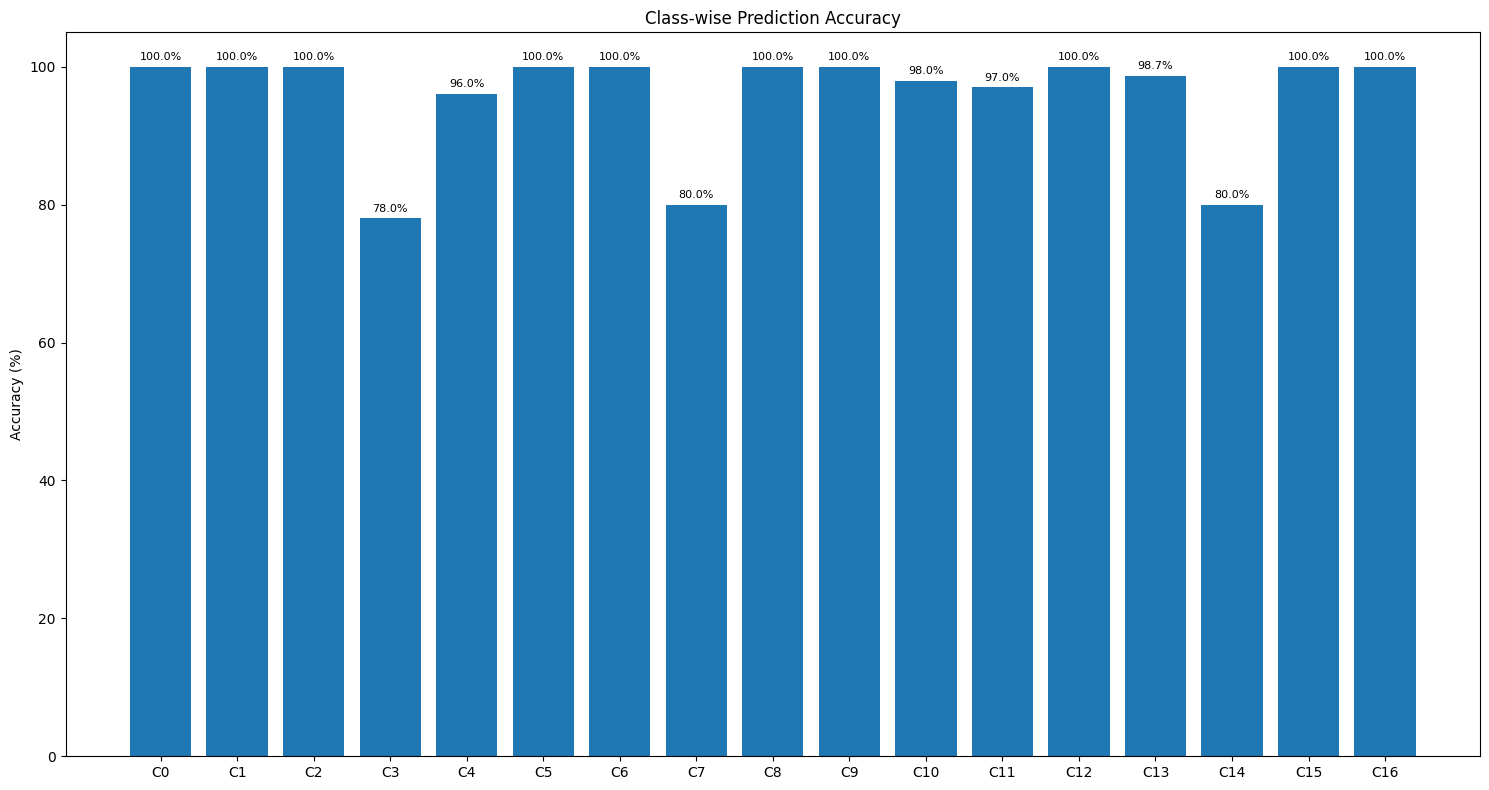

Worst 3 classes:
Class 3: 78.0%
Class 7: 80.0%
Class 14: 80.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 모델 저장 - 현재 상태 그대로 저장
def save_models():
    """학습한 모델들을 저장"""
    
    # 저장 디렉토리 생성
    save_dir = "models"
    os.makedirs(save_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("🚨 모델 저장 시작...")
    
    # 각 fold별 모델 저장 (fold_models 리스트가 있다고 가정)
    try:
        for fold in range(5):  # 5-fold라고 가정
            model_path = f"{save_dir}/fold_{fold}_model_{timestamp}.pth"
            
            # fold_models[fold]가 존재한다면 저장
            if 'fold_models' in globals() and len(fold_models) > fold:
                torch.save({
                    'model_state_dict': fold_models[fold].state_dict(),
                    'fold': fold,
                    'timestamp': timestamp,
                    'epoch': 'unknown',  # 에포크 정보 모르면 unknown
                }, model_path)
                print(f"✅ Fold {fold} 모델 저장 완료: {model_path}")
            
            # 또는 best_models 리스트가 있다면
            elif 'best_models' in globals() and len(best_models) > fold:
                torch.save({
                    'model_state_dict': best_models[fold].state_dict(),
                    'fold': fold,
                    'timestamp': timestamp,
                    'epoch': 'unknown',
                }, model_path)
                print(f"✅ Fold {fold} best 모델 저장 완료: {model_path}")
                
    except Exception as e:
        print(f"❌ Fold별 저장 실패: {e}")
    
    # 전체 변수 상태 저장 (혹시 모르니까)
    try:
        state_path = f"{save_dir}/full_state_{timestamp}.pth"
        
        # 현재 글로벌 변수에서 모델 관련 객체들 찾아서 저장
        save_dict = {}
        
        # 가능한 모델 변수명들 체크
        possible_model_vars = ['model', 'models', 'fold_models', 'best_models', 
                              'tta_models', 'ensemble_models']
        
        for var_name in possible_model_vars:
            if var_name in globals():
                save_dict[var_name] = globals()[var_name]
                print(f"✅ {var_name} 변수 포함됨")
        
        if save_dict:
            torch.save(save_dict, state_path)
            print(f"✅ 전체 상태 저장 완료: {state_path}")
        
    except Exception as e:
        print(f"❌ 전체 상태 저장 실패: {e}")
    
    print(f"🎉 저장 완료! 저장 위치: {save_dir}/")
    print(f"📁 파일 목록:")
    for file in os.listdir(save_dir):
        print(f"   - {file}")

In [14]:
save_models()

🚨 모델 저장 시작...
❌ Fold별 저장 실패: 'collections.OrderedDict' object has no attribute 'state_dict'
✅ model 변수 포함됨
✅ fold_models 변수 포함됨


✅ 전체 상태 저장 완료: models/full_state_20250911_051817.pth
🎉 저장 완료! 저장 위치: models/
📁 파일 목록:
   - full_state_20250911_015439.pth
   - full_state_20250911_051817.pth
   - full_state_20250910_113123.pth


In [15]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [17]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [18]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [19]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [20]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [21]:
# 계층적 TTA 추론 함수
def hierarchical_tta_inference(main_models, detector_models, specializer_models, loader, device):
    """계층적 모델들을 사용한 TTA 추론"""
    print("🎯 Starting Hierarchical TTA Inference...")
    
    n_folds = len(main_models)
    fold_predictions = []
    total_stats = {
        'total_samples': 0,
        'total_detection_needed': 0,
        'total_specializer_used': 0
    }
    
    for fold in range(n_folds):
        print(f"Processing Hierarchical Fold {fold + 1}/{n_folds}...")
        
        # 계층적 분류기 구성
        hierarchical_model = HierarchicalDocumentClassifier(main_model_name=model_name)
        
        # 메인 모델 로드 (기존 fold_models의 state_dict 사용)
        hierarchical_model.main_classifier.load_state_dict(main_models[fold])
        
        # 탐지기와 전용 분류기 로드
        if detector_models[fold] is not None:
            try:
                hierarchical_model.weak_detector.load_state_dict(detector_models[fold])
            except Exception as e:
                print(f"Warning: Failed to load detector for fold {fold}: {e}")
                # 백업 방법: 새 모델 생성해서 로드
                temp_detector = WeakClassDetector().to(device)
                temp_detector.load_state_dict(detector_models[fold])
                hierarchical_model.weak_detector = temp_detector
                
        if specializer_models[fold] is not None:
            try:
                hierarchical_model.weak_specializer.load_state_dict(specializer_models[fold])
            except Exception as e:
                print(f"Warning: Failed to load specializer for fold {fold}: {e}")
                # 백업 방법: 새 모델 생성해서 로드
                temp_specializer = WeakClassSpecializer().to(device)
                temp_specializer.load_state_dict(specializer_models[fold])
                hierarchical_model.weak_specializer = temp_specializer
            
        hierarchical_model.eval()
        hierarchical_model.to(device)
        
        fold_preds = []
        fold_stats = {'detection_needed': 0, 'total': 0}
        
        with torch.no_grad():
            for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc=f"Hierarchical Fold {fold+1}")):
                batch_size = images_list[0].size(0)
                batch_ensemble_probs = torch.zeros(batch_size, 17).to(device)
                
                # 각 TTA 변형에 대해 계층적 추론
                for tta_idx, images in enumerate(images_list):
                    images = images.to(device)
                    
                    # 조건부 계층적 추론 사용
                    probs = hierarchical_model(images, mode='inference')
                    batch_ensemble_probs += probs / len(images_list)
                    
                    # 통계 수집 (첫 번째 TTA에서만)
                    if tta_idx == 0:  # 첫 번째 TTA 변형에서만 통계 수집
                        stats = hierarchical_model.get_inference_stats(images)
                        fold_stats['detection_needed'] += stats['detection_needed']
                        fold_stats['total'] += stats['total_samples']
                
                final_preds = torch.argmax(batch_ensemble_probs, dim=1)
                fold_preds.extend(final_preds.cpu().numpy())
        
        # 폴드 통계 출력- ZeroDivisionError 방지
        if fold_stats['total'] > 0:
            detection_ratio = fold_stats['detection_needed'] / fold_stats['total']
            print(f"  Fold {fold+1} - Detection needed: {fold_stats['detection_needed']}/{fold_stats['total']} ({detection_ratio:.1%})")
        else:
            print(f"  Fold {fold+1} - No samples processed (possible issue with stats collection)")
        
        total_stats['total_samples'] += fold_stats['total']
        total_stats['total_detection_needed'] += fold_stats['detection_needed']
        
        fold_predictions.append(fold_preds)
    
    # 전체 통계 출력
    overall_detection_ratio = total_stats['total_detection_needed'] / total_stats['total_samples']
    print(f"\n📊 Overall Detection Statistics:")
    print(f"  Total samples: {total_stats['total_samples']}")
    print(f"  Detection needed: {total_stats['total_detection_needed']} ({overall_detection_ratio:.1%})")
    print(f"  Efficiency gain: {1-overall_detection_ratio:.1%} samples skipped detection")
    
    # Fold 앙상블 (다수결)
    final_predictions = []
    for i in range(len(fold_predictions[0])):
        votes = [fold_preds[i] for fold_preds in fold_predictions]
        final_pred = Counter(votes).most_common(1)[0][0]
        final_predictions.append(final_pred)
    
    return final_predictions


In [22]:
# 앙상블 TTA 실행 (기존 방법)
print("Starting Original Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

# 계층적 앙상블 TTA 추가 실행
print("\nStarting Hierarchical Ensemble TTA inference...")

# 기존 모델들의 state_dict 추출
main_model_states = [model.state_dict() for model in ensemble_models]

hierarchical_predictions = hierarchical_tta_inference(
    main_models=main_model_states,
    detector_models=detector_models,
    specializer_models=specializer_models,
    loader=tta_loader,
    device=device
)

Starting Original Ensemble TTA inference...


Ensemble TTA:   0%|          | 0/50 [00:00<?, ?it/s]

Ensemble TTA: 100%|██████████| 50/50 [16:36<00:00, 19.94s/it]



Starting Hierarchical Ensemble TTA inference...
🎯 Starting Hierarchical TTA Inference...
Processing Hierarchical Fold 1/5...


Hierarchical Fold 1: 100%|██████████| 50/50 [04:41<00:00,  5.64s/it]


  Fold 1 - Detection needed: 311/3140 (9.9%)
Processing Hierarchical Fold 2/5...


Hierarchical Fold 2: 100%|██████████| 50/50 [04:29<00:00,  5.39s/it]


  Fold 2 - Detection needed: 382/3140 (12.2%)
Processing Hierarchical Fold 3/5...


Hierarchical Fold 3: 100%|██████████| 50/50 [04:26<00:00,  5.32s/it]


  Fold 3 - Detection needed: 357/3140 (11.4%)
Processing Hierarchical Fold 4/5...


Hierarchical Fold 4: 100%|██████████| 50/50 [04:43<00:00,  5.67s/it]


  Fold 4 - Detection needed: 494/3140 (15.7%)
Processing Hierarchical Fold 5/5...


Hierarchical Fold 5: 100%|██████████| 50/50 [04:23<00:00,  5.27s/it]

  Fold 5 - Detection needed: 348/3140 (11.1%)

📊 Overall Detection Statistics:
  Total samples: 15700
  Detection needed: 1892 (12.1%)
  Efficiency gain: 87.9% samples skipped detection


In [23]:
# 결과 비교 분석
print(f"\n📊 Prediction Comparison:")
print(f"Original unique predictions: {len(set(tta_predictions))}")
print(f"Hierarchical unique predictions: {len(set(hierarchical_predictions))}")

# 예측 일치도 분석
agreement_count = sum(1 for i, j in zip(tta_predictions, hierarchical_predictions) if i == j)
total_count = len(tta_predictions)
agreement_ratio = agreement_count / total_count

print(f"Prediction agreement: {agreement_count}/{total_count} ({agreement_ratio:.1%})")

# 취약 클래스 예측 분석
weak_classes = [3, 4, 7, 14]
original_weak_count = sum(1 for p in tta_predictions if p in weak_classes)
hierarchical_weak_count = sum(1 for p in hierarchical_predictions if p in weak_classes)

print(f"Original weak class predictions: {original_weak_count}")
print(f"Hierarchical weak class predictions: {hierarchical_weak_count}")

# 차이점 분석
disagreement_indices = [i for i, (orig, hier) in enumerate(zip(tta_predictions, hierarchical_predictions)) if orig != hier]
print(f"Disagreement count: {len(disagreement_indices)} samples")

if len(disagreement_indices) > 0:
    print("Disagreement examples (first 10):")
    for i in disagreement_indices[:10]:
        print(f"  Sample {i}: Original={tta_predictions[i]}, Hierarchical={hierarchical_predictions[i]}")

# 원본 TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

# 계층적 TTA 결과로 submission 파일 생성
hierarchical_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
hierarchical_pred_df['target'] = hierarchical_predictions

# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()
assert (sample_submission_df['ID'] == hierarchical_pred_df['ID']).all()

# 두 결과 모두 저장
tta_pred_df.to_csv("../submission/original_choice.csv", index=False)
hierarchical_pred_df.to_csv("../submission/hierarchical_choice.csv", index=False)

print("✅ Both submissions saved:")
print("   - original_choice.csv (기존 방법)")
print("   - hierarchical_choice.csv (계층적 방법)")

# 최종 분석
print(f"\n📊 Final Analysis:")
print(f"Total test samples: {len(hierarchical_predictions)}")

# 클래스별 예측 분포 비교
original_dist = Counter(tta_predictions)
hierarchical_dist = Counter(hierarchical_predictions)

print(f"\n📋 클래스별 예측 분포 비교:")
for cls in sorted(set(list(original_dist.keys()) + list(hierarchical_dist.keys()))):
    orig_count = original_dist.get(cls, 0)
    hier_count = hierarchical_dist.get(cls, 0)
    diff = hier_count - orig_count
    marker = "🎯" if cls in [3, 4, 7, 14] else "📋"
    print(f"  {marker} Class {cls}: Original={orig_count}, Hierarchical={hier_count}, Diff={diff:+d}")

print("\nHierarchical TTA Prediction sample:")
print(hierarchical_pred_df.head())


📊 Prediction Comparison:
Original unique predictions: 17
Hierarchical unique predictions: 17
Prediction agreement: 3033/3140 (96.6%)
Original weak class predictions: 688
Hierarchical weak class predictions: 694
Disagreement count: 107 samples
Disagreement examples (first 10):
  Sample 16: Original=4, Hierarchical=3
  Sample 26: Original=7, Hierarchical=3
  Sample 70: Original=14, Hierarchical=3
  Sample 74: Original=7, Hierarchical=3
  Sample 83: Original=7, Hierarchical=3
  Sample 94: Original=7, Hierarchical=3
  Sample 101: Original=7, Hierarchical=3
  Sample 131: Original=4, Hierarchical=3
  Sample 231: Original=7, Hierarchical=3
  Sample 276: Original=4, Hierarchical=3
✅ Both submissions saved:
   - original_choice.csv (기존 방법)
   - hierarchical_choice.csv (계층적 방법)

📊 Final Analysis:
Total test samples: 3140

📋 클래스별 예측 분포 비교:
  📋 Class 0: Original=200, Hierarchical=200, Diff=+0
  📋 Class 1: Original=88, Hierarchical=88, Diff=+0
  📋 Class 2: Original=200, Hierarchical=200, Diff=+0
 